# Neuroplant image analysis
This notebook analyzes chemotaxis assays as part of the neuroplant project, which seeks to use C. elegans nematodes to identify neuroactive compounds in plants.

### To-dos
- connect to metadata spreadsheets
- decode strains and compounds
- integrate diagnostic plots into functions
- compare automated and manual analysis

## First, load libraries

In [1]:
import pandas as pd
import time
import skimage
from skimage import feature
from skimage import morphology
from skimage import measure
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import ndimage as ndi
import numpy as np
import pathlib
import csv
#import gspread
#import pydrive

start = time.time()

## File parameters

In [2]:
plate_number = 1
base_folder = pathlib.Path('/Users/adam/Documents/Neuroplant/')
image_location = base_folder.joinpath('Images')
results_location = base_folder.joinpath('automated_analysis_results')

## Functions for running analysis
### Load data

In [3]:
def load_image_data(data_location, plate_id):
   
    pre_file = data_location.joinpath(plate_id + '_Pre.tif')
    pre_image = skimage.io.imread(pre_file)

    # select bounds of the lane we're working on now
#     if lane == 'P':
#         upper_boundary = 23000
#         lower_boundary = pre_image.shape[0]
#     elif lane == 'Q':
#         upper_boundary = 14800
#         lower_boundary = 23000
#     elif lane == 'R':
#         upper_boundary = 6900
#         lower_boundary = 14800
#     elif lane == 'S':
#         upper_boundary = 0
#         lower_boundary = 6900
#     else:
#         raise ValueError('Lane label not recognized.')

#     pre_image = pre_image[int(3*pre_image.shape[0]/4):pre_image.shape[0],:]#[0:int(pre_image.shape[0]/4),:]
#     pre_image = pre_image[upper_boundary:lower_boundary, :]
    
    fin_file = data_location.joinpath('NPP'+ f"{plate_number:03d}" + '_Fin.tif')
    fin_image = skimage.io.imread(fin_file)
#     fin_image = fin_image[int(3*fin_image.shape[0]/4):fin_image.shape[0],:]#[0:int(fin_image.shape[0]/4),:]
#     fin_image = fin_image[upper_boundary:lower_boundary, :]

    # Crop larger image to make before and after images the same size
#     x_min = 0
#     x_max = min(pre_image.shape[1], fin_image.shape[1])
#     y_min = 0
#     y_max = min(pre_image.shape[0], fin_image.shape[0])
#     pre_image = pre_image[y_min:y_max, x_min:x_max]
#     fin_image = fin_image[y_min:y_max, x_min:x_max]

    return pre_image, fin_image

def crop_to_one_well(pre_image, fin_image, well_id):
    # select bounds of the lane we're working on now
    if well_id == 'P':
        upper_boundary = 23000
        lower_boundary = pre_image.shape[0]
    elif well_id == 'Q':
        upper_boundary = 14800
        lower_boundary = 23000
    elif well_id == 'R':
        upper_boundary = 6900
        lower_boundary = 14800
    elif well_id == 'S':
        upper_boundary = 0
        lower_boundary = 6900
    else:
        raise ValueError('Lane label not recognized.')
        
    pre_image = pre_image[upper_boundary:lower_boundary, :]
    fin_image = fin_image[upper_boundary:lower_boundary, :]
        
    # Crop larger image to make before and after images the same size
    x_min = 0
    x_max = min(pre_image.shape[1], fin_image.shape[1])
    y_min = 0
    y_max = min(pre_image.shape[0], fin_image.shape[0])
    pre_image = pre_image[y_min:y_max, x_min:x_max]
    fin_image = fin_image[y_min:y_max, x_min:x_max]
    
    return pre_image, fin_image

### Find the worms

In [4]:
def find_worms(pre_image, fin_image):
    feature_find_start = time.time()
    
    ## Subtract background
    bkg_subtract = np.subtract(pre_image.astype('int16'),
                               fin_image.astype('int16'))
    bkg_subtract[bkg_subtract < 0] = 0
    bkg_subtract = bkg_subtract.astype('uint8')

    ## Threshold to get binary image
    thresh = skimage.filters.threshold_otsu(bkg_subtract)
    binarized = bkg_subtract > thresh
    # print('Binarization threshold is', str(thresh))

    ## Find features in binary image
    labeled_array, num_features = ndi.label(binarized)
    all_regions = measure.regionprops(label_image=labeled_array, intensity_image=fin_image,
                                      coordinates='rc')

    filtered_regions = []
    for region in all_regions:
        area = region.area
        if area >= 2000 and area <=30000:
            filtered_regions.append(region)
        
#     print('Worm finding and filtering took', str(int(time.time() - feature_find_start)), 'seconds.')
    
    return filtered_regions

### Save worm locations

In [5]:
def save_worm_locations(filename, worms):
    with open(filename, 'w', newline='') as csvfile:
        worm_writer = csv.writer(csvfile, delimiter=',')
        worm_writer.writerow([' ','X','Y']) # header row
        
        worm_num = 1
        for worm in worms:
            worm_writer.writerow([worm_num, worm.centroid[0], worm.centroid[1]])
            worm_num += 1

### Calculate the chemotaxis index

In [6]:
def calc_chemotaxis_index(worm_regions):
    ## Assign features to zones of the plate
    left_area_boundary = 8700 #int(fin_image.shape[1]/3)
    right_area_boundary = 12000 #int(2 * (fin_image.shape[1] / 3))

    left_side_worms = [worm for worm in worm_regions if worm.centroid[1] <= left_area_boundary]
    middle_worms = [worm for worm in worm_regions 
                    if worm.centroid[1] > left_area_boundary and worm.centroid[1] < right_area_boundary]
    right_side_worms = [worm for worm in worm_regions if worm.centroid[1] >= right_area_boundary]
    
#                       filtered_regions[[centroid[1] <= left_area_boundary 
#                                         for centroid in filtered_regions['centroid']]]
#     middle_worms = filtered_regions[[centroid[1] > left_area_boundary and centroid[1] <= right_area_boundary 
#                                      for centroid in filtered_regions['centroid']]]
#     right_side_worms = filtered_regions[[centroid[1] > right_area_boundary 
#                                          for centroid in filtered_regions['centroid']]]
    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(worm_regions)

    chemotaxis_index = worms_in_right_region / total_worms_found
    print('Chemotaxis index is', str(chemotaxis_index))
    
    x_coords = []
    y_coords = []
    for worm in worm_regions:
#         x_sum += worm.centroid[0]
#         y_sum += worm.centroid[1]
        x_coords.append(worm.centroid[0])
        y_coords.append(worm.centroid[1])
    
    centroid = (sum(x_coords)/len(x_coords), sum(y_coords)/len(y_coords))
    
    return chemotaxis_index, centroid

## Do the image analysis

In [7]:
# load_start = time.time()
# well_id = 'P'
# plate_id = 'NPP001'
# pre_image, fin_image = load_image_data(image_location, plate_id, well_id)

# analysis_start = time.time()
# print('Image loading took', str(int(analysis_start-load_start)), 'seconds.')
# worms = find_worms(pre_image, fin_image)
# save_worm_locations(results_location.joinpath(plate_id + '_automatedAnalyzer_' + well_id + '.csv'), worms)
# chemotaxis_index = calc_chemotaxis_index(worms)

# print('Image analysis took', str(int(time.time()-analysis_start)), 'seconds.')
# print('Entire process took', str(int(time.time()-start)), 'seconds.')

## Loop through all plates

In [8]:
loop_start = time.time()

results_list = []
for image in image_location.glob('NPP*Fin.tif'): 
    plate_start = time.time()
    plate_id = image.stem[0:6]
    if image.parent.joinpath(plate_id + '_Pre.tif').exists is False:
        raise NameError('No matching pre-image found.')
    
    # Load the entire image
    pre_image, fin_image = load_image_data(image_location, plate_id)
    
    for well_id in ['P', 'Q', 'R', 'S']:
        # Process on well at a time
        cropped_pre_image, cropped_fin_image = crop_to_one_well(pre_image, fin_image, well_id)
        worms = find_worms(cropped_pre_image, cropped_fin_image)
        
        # Save the results
        filename = results_location.joinpath(plate_id + '_automatedAnalyzer_' + well_id + '.csv')
        save_worm_locations(filename, worms)
        
        # Calculate chemotaxis index and gather into a dataframe
        chemotaxis_index, centroid = calc_chemotaxis_index(worms)
        results_dict = {'Plate_id': plate_id,
                        'Well_id': well_id,
                        'results_file': filename,
                        'chemotaxis_index': chemotaxis_index,
                        'centroid_x': centroid[0],
                        'centroid_y': centroid[1]}
        results_list.append(results_dict)
        
    print('Finished a plate in', str(int(time.time()-plate_start)), 'seconds.')

results_df = pd.DataFrame(results_list)
results_df.to_csv(path_or_buf=base_folder.joinpath('chemotaxis_summary.csv'))
print('Finished everything in', str(int(time.time()-loop_start)), 'seconds.')

Chemotaxis index is 0.6528925619834711
Chemotaxis index is 0.46543778801843316
Chemotaxis index is 0.5333333333333333
Chemotaxis index is 0.5745192307692307
Finished a plate in 66 seconds.
Chemotaxis index is 0.6283783783783784
Chemotaxis index is 0.4645669291338583
Chemotaxis index is 0.4435146443514644
Chemotaxis index is 0.5822050290135397
Finished a plate in 59 seconds.
Chemotaxis index is 0.16065573770491803
Chemotaxis index is 0.47540983606557374
Chemotaxis index is 0.17110266159695817
Chemotaxis index is 0.5818965517241379
Finished a plate in 118 seconds.
Finished everything in 244 seconds.


# Diagnostic plots

In [9]:
#     props = [a for a in dir(all_regions[0]) if not a.startswith('_')]
props = ['area', 'convex_area', 'bbox', 'centroid']

region_df = pd.DataFrame([{prop: getattr(worm, prop) for prop in props} for worm in worms])

## Filter features
filtered_regions = region_df[
    (region_df['area'] >= 2000) &
    (region_df['area'] <= 30000)]

In [10]:
cropped_fin_image.shape

(6900, 21069)

## Plot results of feature find

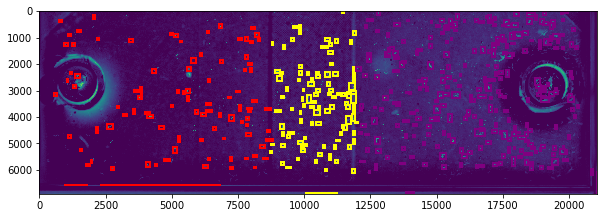

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
## Subtract background
bkg_subtract = np.subtract(cropped_pre_image.astype('int16'),
                           cropped_fin_image.astype('int16'))
bkg_subtract[bkg_subtract < 0] = 0
bkg_subtract = bkg_subtract.astype('uint8')

## Threshold to get binary image
thresh = skimage.filters.threshold_otsu(bkg_subtract)
binarized = bkg_subtract > thresh
# print('Binarization threshold is', str(thresh))

## Find features in binary image
labeled_array, num_features = ndi.label(binarized)
all_regions = measure.regionprops(label_image=labeled_array, intensity_image=cropped_fin_image,
                                  coordinates='rc')
ax.imshow(bkg_subtract)


left_area_boundary = 8700 #int(fin_image.shape[1]/3)
right_area_boundary = 12000 #int(2 * (fin_image.shape[1] / 3))
left_side_worms = filtered_regions[[centroid[1] <= left_area_boundary 
                                    for centroid in filtered_regions['centroid']]]
middle_worms = filtered_regions[[centroid[1] > left_area_boundary and centroid[1] <= right_area_boundary 
                                 for centroid in filtered_regions['centroid']]]
right_side_worms = filtered_regions[[centroid[1] > right_area_boundary 
                                     for centroid in filtered_regions['centroid']]]


for index, row in left_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

for index, row in middle_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='yellow', linewidth=2)
    ax.add_patch(rect)
    
for index, row in right_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='purple', linewidth=2)
    ax.add_patch(rect)
    
# ax.set_ylim(2000, 4000)
# ax.set_xlim(0, 2500);
# fig.savefig('../filtered_regions.pdf')

In [12]:
# all_regions[0].centroid
x_coords = []
y_coords = []
for region in worms:
    x_coords.append((region.centroid[0]))
    y_coords.append((region.centroid[1]))

In [13]:
sum(x_coords) / len(x_coords)

3181.222124443473

## Show results in detailed region

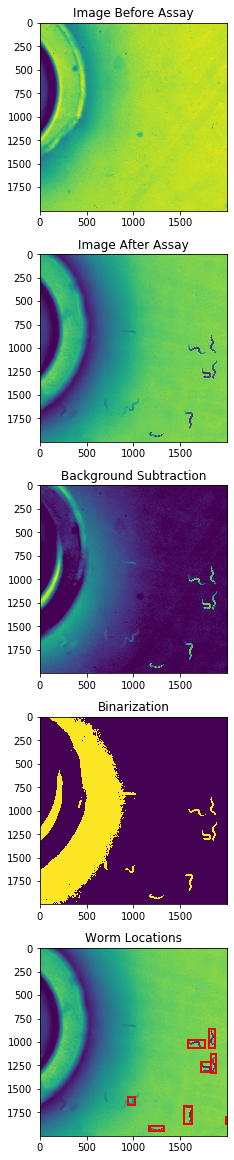

In [14]:
x_min = 2000
x_max = 4000
y_min = 2000
y_max = 4000

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 16), constrained_layout=True)
axes[0].imshow(cropped_pre_image[y_min:y_max, x_min:x_max])
axes[0].set_title('Image Before Assay')

axes[1].imshow(cropped_fin_image[y_min:y_max, x_min:x_max])
axes[1].set_title('Image After Assay')

axes[2].imshow(bkg_subtract[y_min:y_max, x_min:x_max])
axes[2].set_title('Background Subtraction')

axes[3].imshow(binarized[y_min:y_max, x_min:x_max])
axes[3].set_title('Binarization')

axes[4].imshow(fin_image[y_min:y_max, x_min:x_max])
axes[4].set_title('Worm Locations')
for index, row in left_side_worms.iterrows():
    minr, minc, maxr, maxc = row['bbox']
    minr -= y_min
    minc -= x_min
    maxr -= y_min
    maxc -= x_min
    rect = mpl.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    axes[4].add_patch(rect)

## Show images of all the things we think are worms

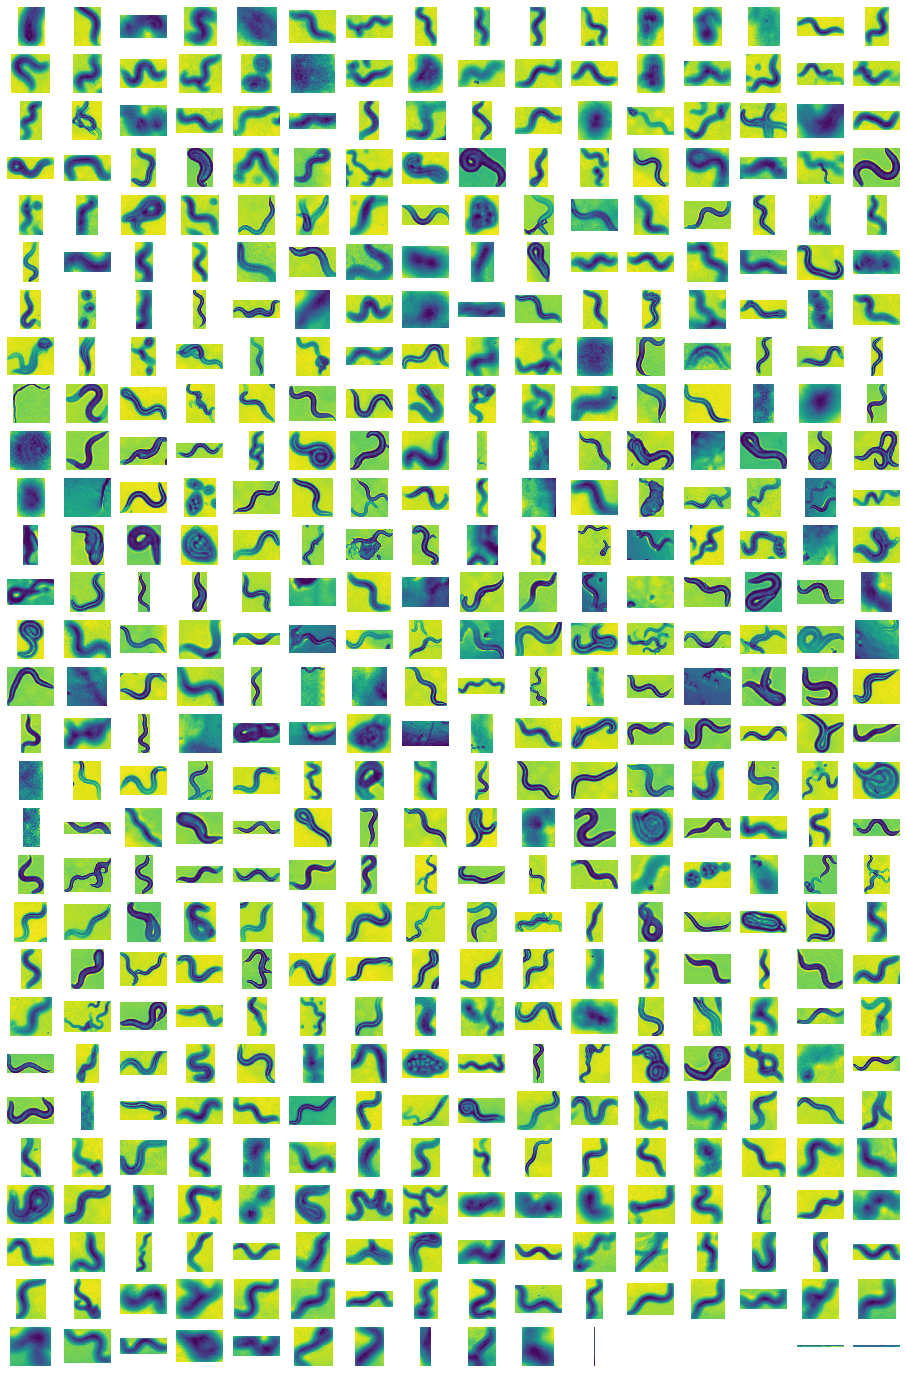

In [15]:
nrows = int(len(filtered_regions) / 16)
fig, axes = plt.subplots(nrows=nrows, ncols=16, figsize=(16, 25))
pad = 0
bboxes = filtered_regions['bbox'].values
region_num = 0
for row in range(0,nrows):
    for col in range(0,16):
        bbox = bboxes[region_num]
        axes[row, col].imshow(fin_image[bbox[0]-pad:bbox[2]+pad,bbox[1]-pad:bbox[3]+pad])
        axes[row, col].axis('off')
        region_num += 1

In [16]:
# fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 10))
# axes[0].imshow(bkg_subtract[y_min:y_max, x_min:x_max])
# axes[1.imshow(binarized[y_min:y_max, x_min:x_max])
# fig.savefig('../binarized_section_of image.png')

In [17]:
# regions = morphology.watershed(image=bkg_subtract[3500:4500, 2500:3500],# watershed_line=True, 
#                                compactness=.01,#,#markers=labeled_array[3500:4500, 2500:3500],
#                                mask=binarized[3500:4500, 2500:3500])
# # print(str(int(time.time()-start)))
# fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
# # axes[0].imshow(binarized[3500:4500, 2500:3500])
# axes.imshow(regions, cmap=plt.cm.gray)

In [18]:
# edges = feature.canny(bkg_subtract[3500:4500, 2500:3500], low_threshold=5, high_threshold=19, sigma=1)
# filled_worms = ndi.binary_fill_holes(edges)#, structure=np.ones((3,3)))

In [19]:
# fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 20))
# axes[0].imshow(edges, cmap=plt.cm.gray)
# axes[1].imshow(filled_worms, cmap=plt.cm.gray)

In [20]:
# plt.hist(pre_image.flatten(), bins=16)
# plt.show()

In [21]:
# plt.hist(fin_image.flatten(), bins=16)
# plt.show()

In [22]:
# plt.hist(bkg_subtract.flatten(), bins=16)
# plt.show()

In [23]:
print('Notebook ran in', str(int(time.time()-start)), 'seconds.')

Notebook ran in 307 seconds.
